In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO
import seaborn as sns
import random 
import akita_utils 
import pysam
import time 
import h5py
genome_fasta = '/project/fudenber_735/genomes/mm10/mm10.fa'
genome_open = pysam.Fastafile('/project/fudenber_735/genomes/mm10/mm10.fa')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow as tf
print(tf.__version__)

import pysam
from basenji import dataset, seqnn, dna_io,stream
head_i = 1 #mouse
model_num = 1 #which fold to use

base_dir = '/project/fudenber_735/tensorflow_models/akita/v2/models/'
model_dir = base_dir+"/f"+str(model_num)+"c0/train/"
model_file  = model_dir+'/model'+str(head_i)+'_best.h5'

params_file = model_dir+'/params.json'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']
seq_length = params_model['seq_length']
params_model['verbose'] = False
seqnn_model = seqnn.SeqNN(params_model)
print('built')
seqnn_model.restore(model_file, head_i=head_i)
print('restored')

hic_diags = params_model['diagonal_offset']
try:
    target_crop = params_model['trunk'][-2]['cropping']
except:
    target_crop = params_model['target_crop']
target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags)* ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size,2)
target_map_size, target_length_cropped, triu_tup[0].shape

2.4.1


2022-07-24 07:33:10.559867: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


built
restored


(512, 130305, (130305,))

# Fetching chromosome data to explore background creation

In [3]:
chromsizes = bioframe.read_chromsizes('/project/fudenber_735/tensorflow_models/akita/v2/data/mm10/sequences.bed')
dframe = pd.DataFrame(chromsizes)
dframe['end'] = dframe['length']+ 1310720
dframe = dframe.reset_index()
dframe.rename(columns = {'index' : 'chrom', 'length':'start'}, inplace = True)
df = bioframe.frac_gc(dframe, bioframe.load_fasta('/project/fudenber_735/genomes/mm10/mm10.fa'), return_input=True)

df

,chrom,start,end,GC
0,chr1,40415232,41725952,0.407777
1,chr1,42708992,44019712,0.424985
2,chr1,42053632,43364352,0.424847
3,chr1,41725952,43036672,0.411407
4,chr1,43036672,44347392,0.417725
...,...,...,...,...
6033,chrX,99241984,100552704,0.424162
6034,chrX,120532992,121843712,0.367963
6035,chrX,139360256,140670976,0.407839
6036,chrX,128737280,130048000,0.370827


In [4]:
# df.iloc[6][['chrom','start','end','GC']]
# plt.hist( df['GC'].values, 100);
# np.percentile(df['GC'].dropna().values, np.linspace(1,99,50))

# Generating a sample for down stream analysis

In [5]:
super_set = []
error = 0.01

for gc in np.percentile(df['GC'].dropna().values, np.linspace(1,99,50)):
    for i in range(df.shape[0]):
        if gc-error <= df['GC'].values[i] <= gc+error:
            super_set += [i]
            break

super_set = list(set(super_set)); print(f'Whole distribution: {super_set}')
sample_set = super_set; print(f'Sampled datapoints: {sample_set}')
new_dataframe = df.iloc[[ind for ind in set(sample_set)]] 

Whole distribution: [0, 1, 32, 5, 6, 7, 8, 10, 12, 20, 24, 475, 28, 95]
Sampled datapoints: [0, 1, 32, 5, 6, 7, 8, 10, 12, 20, 24, 475, 28, 95]


In [6]:
def mutation_search(seqnn_model,
                    genome_fasta,
                    seq_length,
                    dataframe,
                    max_iters=1,
                    batch_size=6,
                    shuffle_k=8,
                    ctcf_thresh=8,
                    scores_thresh = 5500,
                    scores_pixelwise_thresh = .04,
                    masking=False,
                    timing = False
                    ):
    """
    This function creates flat sequences
    """
    flat_seqs = []
    scores_storage = {}
    num_seqs = dataframe.shape[0]

    mot = ">CCAsyAGrkGGCr\n0.0000\t1.0000\t0.0000\t0.0000\n0.0000\t1.0000\t0.0000\t0.0000\n1.0000\t0.0000\t0.0000\t0.0000\n0.0000\t0.5000\t0.5000\t0.0000\n0.0000\t0.5000\t0.0000\t0.5000\n1.0000\t0.0000\t0.0000\t0.0000\n0.0000\t0.0000\t1.0000\t0.0000\n0.5000\t0.0000\t0.5000\t0.0000\n0.0000\t0.0000\t0.5000\t0.5000\n0.0000\t0.0000\t1.0000\t0.0000\n0.0000\t0.0000\t1.0000\t0.0000\n0.0000\t1.0000\t0.0000\t0.0000\n0.5000\t0.0000\t0.5000\t0.0000"
    motif = pd.read_csv(StringIO(mot), sep="\t", header=0, names=["A", "C", "G", "T"]).values
    motif_window = int(np.ceil(len(motif) / 2))
    mot_shuf = [12, 0, 1, 11, 10, 3, 2, 8, 9, 4, 5, 7, 6, 13]

    for ind in range(num_seqs):
        chrom, start, end, gc = dataframe.iloc[ind][["chrom", "start", "end", "GC"]]
        genome_open = pysam.Fastafile(genome_fasta)
        seq = genome_open.fetch(chrom, start, end).upper()
        seq_1hot = dna_io.dna_1hot(seq)

        t0 = time.time()
        num_iters = 0
        while num_iters < max_iters:
            name = f'{num_iters}'
            scores_set = []
            print("ind",ind,", iter ",num_iters,", k ",shuffle_k,", for", chrom, start, end,)
            seq_1hot_batch = []
            for i in range(batch_size):
                seq_1hot_mut = akita_utils.permute_seq_k(seq_1hot, k=shuffle_k)
                s = akita_utils.scan_motif(seq_1hot_mut, motif)
                if masking == 0:
                    for i in np.where(s > ctcf_thresh)[0]:
                        if len(seq_1hot_mut[i-motif_window:i+motif_window]) == len(mot_shuf):
                            seq_1hot_mut[i-motif_window:i+motif_window] = akita_utils.permute_seq_k(seq_1hot_mut[i-motif_window:i+motif_window], k=2)
                    seq_1hot_batch.append(seq_1hot_mut)
                elif masking == 1:
                    for i in np.where(s > ctcf_thresh)[0]:
                        if len(seq_1hot_mut[i-motif_window:i+motif_window]) == len(mot_shuf):
                            seq_1hot_mut[i-motif_window:i+motif_window] = seq_1hot_mut[i-motif_window:i+motif_window][mot_shuf]

                    seq_1hot_batch.append(seq_1hot_mut)
                else:
                    seq_1hot_batch.append(seq_1hot_mut)

            seq_1hot_batch = np.array(seq_1hot_batch)
            pred = seqnn_model.predict(seq_1hot_batch, batch_size=batch_size)
            scores = np.sum(pred**2, axis=-1).sum(axis=-1)
            scores_pixelwise = np.max(pred**2, axis=-1).max(axis=-1)  
            t1 = time.time()

            if np.any([
                (np.min(scores) < scores_thresh)
                , (np.min(scores_pixelwise) < scores_pixelwise_thresh)]
            ):
                scores_set += [scores]
                best_ind = np.argmin(scores_pixelwise)
                best_seq = seq_1hot_batch[best_ind]
                best_pred = pred[best_ind]
                best_score, best_score_pixelwise = (
                    scores[best_ind],
                    scores_pixelwise[best_ind],
                )
                
                print(
                    "success: best seq, thresh",
                    np.min(scores),
                    " pixelwise",
                    np.min(scores_pixelwise),
                    "time",
                    t1 - t0
                )
                if timing == True:
                    num_iters = max_iters
            else:
                scores_set += [scores]
                best_ind = np.argmin(scores_pixelwise)
                best_seq = seq_1hot_batch[best_ind]
                best_pred = pred[best_ind]
                best_score, best_score_pixelwise = (
                    scores[best_ind],
                    scores_pixelwise[best_ind],
                )
                print(
                "trying: best seq, thresh",
                np.min(scores),
                " pixelwise",
                np.min(scores_pixelwise),
                )
            
            scores_storage[name] = scores_set
            
            num_iters += 1
            if num_iters >= max_iters:
                # scores_set += [scores]
                print(f"max iters exceeded, final time {t1 - t0}")
                if gc :
                    flat_seqs.append([
                    best_seq,
                    best_pred,
                    best_score,
                    best_score_pixelwise,
                    t1 - t0,
                    gc
                ])
                else:
                    flat_seqs.append([
                    best_seq,
                    best_pred,
                    best_score,
                    best_score_pixelwise,
                    t1 - t0
                ])

            

    return scores_storage, flat_seqs

In [8]:
max_iters=10
batch_size=6
# score = 5500

scores_storage_random_masking, flat_seqs_random_masking = mutation_search(    seqnn_model=seqnn_model,
                                                    genome_fasta=genome_fasta,
                                                    seq_length=seq_length,
                                                    dataframe= new_dataframe,
                                                    max_iters=max_iters,
                                                    batch_size=batch_size,
                                                    masking=0,timing = True)

print('**********************************')

scores_storage_motif_masking, flat_seqs_motif_masking = mutation_search(     seqnn_model=seqnn_model,
                                                    genome_fasta=genome_fasta,
                                                    seq_length=seq_length,
                                                    dataframe= new_dataframe,
                                                    max_iters=max_iters,
                                                    batch_size=batch_size,
                                                    masking=1,timing = True)

print('**********************************')

scores_storage_all_random, flat_seqs_no_mask = mutation_search(        seqnn_model=seqnn_model,
                                                    genome_fasta=genome_fasta,
                                                    seq_length=seq_length,
                                                    dataframe= new_dataframe,
                                                    max_iters=max_iters,
                                                    batch_size=batch_size,timing = True)

ind 0 , iter  0 , k  8 , for chr1 40415232 41725952
success: best seq, thresh 5904.0  pixelwise 0.03757 time 11.083017826080322
max iters exceeded, final time 11.083017826080322
ind 1 , iter  0 , k  8 , for chr1 42708992 44019712
trying: best seq, thresh 5936.0  pixelwise 0.05112
ind 1 , iter  1 , k  8 , for chr1 42708992 44019712
trying: best seq, thresh 6670.0  pixelwise 0.0425
ind 1 , iter  2 , k  8 , for chr1 42708992 44019712
success: best seq, thresh 5844.0  pixelwise 0.03882 time 34.21141076087952
max iters exceeded, final time 34.21141076087952
ind 2 , iter  0 , k  8 , for chr1 135311360 136622080
trying: best seq, thresh 10510.0  pixelwise 0.0893
ind 2 , iter  1 , k  8 , for chr1 135311360 136622080
trying: best seq, thresh 12184.0  pixelwise 0.09906
ind 2 , iter  2 , k  8 , for chr1 135311360 136622080
trying: best seq, thresh 11170.0  pixelwise 0.09033
ind 2 , iter  3 , k  8 , for chr1 135311360 136622080
trying: best seq, thresh 10640.0  pixelwise 0.0897
ind 2 , iter  4 , k

{'0': [array([11792., 16560., 12808., 13504., 16928., 12424.], dtype=float16)], '1': [array([12696., 12904., 16752., 13696., 12304., 14880.], dtype=float16)], '2': [array([12928., 18640., 13392., 14448., 15576., 12064.], dtype=float16)], '3': [array([18736., 13416., 15528., 13152., 14248., 13712.], dtype=float16)], '4': [array([11216., 12752., 14648., 13256., 15480., 15816.], dtype=float16)], '5': [array([14704., 18000., 13952., 12768., 15000., 12976.], dtype=float16)], '6': [array([32320., 11688., 13008., 12520., 21808., 14072.], dtype=float16)], '7': [array([11976., 12888., 11568., 17120., 18464., 11856.], dtype=float16)], '8': [array([12480., 34752., 11392., 14064., 22064., 12808.], dtype=float16)], '9': [array([15512., 15176., 13320., 12488., 14000., 12312.], dtype=float16)]}


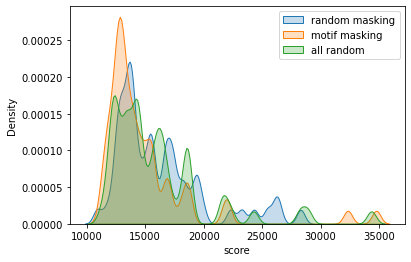

In [9]:
Y_1 = []
Y_2 = []
Y_3 = []

for i in scores_storage_random_masking:
    for j in scores_storage_random_masking[i]:
        Y_1 += j.tolist()

for i in scores_storage_motif_masking:
    for j in scores_storage_motif_masking[i]:
        Y_2 += j.tolist()        

for i in scores_storage_all_random:
    for j in scores_storage_all_random[i]:
        Y_3 += j.tolist()
        
print(scores_storage_motif_masking)

kde_1 = pd.DataFrame(Y_1, columns=["score"])
kde_2 = pd.DataFrame(Y_2, columns=["score"])
kde_3 = pd.DataFrame(Y_3, columns=["score"])
sns.kdeplot(data=kde_1, x="score", bw_adjust=.2, label='random masking', fill=True)  
sns.kdeplot(data=kde_2, x="score", bw_adjust=.2, label='motif masking', fill=True)    
sns.kdeplot(data=kde_3, x="score", bw_adjust=.2, label='all random', fill=True)    
plt.legend()
plt.show()

# Focusing on time taken to obtain a success trial (with and without masking)

In [ ]:
# super_set = []
# error = 0.0001

# for gc in np.percentile(df['GC'].dropna().values, np.linspace(1,99,20)):
#     for i in range(df.shape[0]):
#         if gc-error <= df['GC'].values[i] <= gc+error:
#             super_set += [i]
#             break

# super_set = list(set(super_set)); print(f'Whole distribution: {super_set}')
# sample_set = super_set; print(f'Sampled datapoints: {sample_set}')

In [ ]:
# # Paramaters for all analysis downstream
# max_iters = 10
# batch_size = 5
# shuffle_k = 8 
# ctcf_thresh = 8 
# scores_thresh = 5500 
# scores_pixelwise_thresh = .04
# new_dataframe = df.iloc[[ind for ind in set(sample_set)]]
# # ---------------------------------------------------------------

# # For comparison further down
# shuffle_set = [2,4,8] # shuffling basepairs to sample for comparison
# scores_thresh_set = [5000,5500,6000] # ctcf thresholds to sample for comparison

In [ ]:
# scores_storage,flat_seqs_random_masking = mutation_search(seqnn_model=seqnn_model,
#                                                     genome_fasta=genome_fasta,
#                                                     seq_length=seq_length,
#                                                     dataframe= new_dataframe,
#                                                     max_iters=max_iters,
#                                                     batch_size=batch_size,
#                                                     shuffle_k=8,
#                                                     ctcf_thresh=8,
#                                                     scores_thresh = 5500,
#                                                     scores_pixelwise_thresh = .04,
#                                                     masking=0,
#                                                     timing = True
#                                                     )


# scores_storage,flat_seqs_motif_masking = mutation_search(seqnn_model=seqnn_model,
#                                                     genome_fasta=genome_fasta,
#                                                     seq_length=seq_length,
#                                                     dataframe= new_dataframe,
#                                                     max_iters=1,
#                                                     batch_size=6,
#                                                     shuffle_k=8,
#                                                     ctcf_thresh=8,
#                                                     scores_thresh = 5500,
#                                                     scores_pixelwise_thresh = .04,
#                                                     masking=1,
#                                                     timing = True
#                                                     )

# scores_storage,flat_seqs_no_mask = mutation_search(seqnn_model=seqnn_model,
#                                                     genome_fasta=genome_fasta,
#                                                     seq_length=seq_length,
#                                                     dataframe= new_dataframe,
#                                                     max_iters=1,
#                                                     batch_size=6,
#                                                     shuffle_k=8,
#                                                     ctcf_thresh=8,
#                                                     scores_thresh = 5500,
#                                                     scores_pixelwise_thresh = .04,
#                                                     timing = True
#                                                     )

# Visualizing time taken to obtain a success trial with masking

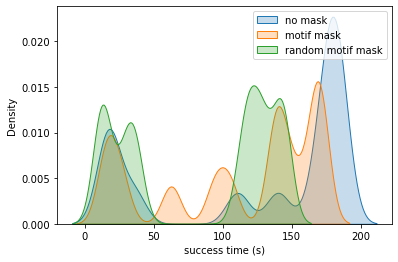

In [10]:
flat_pred_time_random_masking = []
flat_pred_time_motif_masking = []
flat_pred_time_no_mask = []

for i in range(len(sample_set)):
    flat_pred_time_no_mask += [flat_seqs_no_mask[i][4]]
    flat_pred_time_random_masking += [flat_seqs_random_masking[i][4]]
    flat_pred_time_motif_masking += [flat_seqs_motif_masking[i][4]]

kde = pd.DataFrame(flat_pred_time_no_mask, columns=["success time (s)"])    
sns.kdeplot(data=kde, x="success time (s)", bw_adjust=.2, label='no mask', fill=True)    

kde = pd.DataFrame(flat_pred_time_motif_masking, columns=["success time (s)"])    
sns.kdeplot(data=kde, x="success time (s)", bw_adjust=.2, label='motif mask', fill=True)  

kde = pd.DataFrame(flat_pred_time_random_masking, columns=["success time (s)"])    
sns.kdeplot(data=kde, x="success time (s)", bw_adjust=.2, label='random motif mask', fill=True)  

plt.legend()
plt.show()